# Code to train TBX11K classifier

In [20]:
import numpy

In [23]:
print(torch.__version__)
print(torchvision.__version__)
print(numpy.__version__)
print(cv2.__version__)

1.8.1+cu102
0.9.1+cu102
1.22.3
4.5.5


In [1]:
# code based on implementation in:
# https://github.com/linhduongtuan/Tuberculosis_ChestXray_Classifier

In [2]:
# Need reformatted TBX data, please download Google Drive and place in data/:
DATA = 'data/'

In [3]:
import os
import cv2
import re
import PIL
import sys
import json
import time
import timm
import math
import copy
import torch
import pickle
import logging
import fnmatch
import argparse
import itertools
import torchvision
import numpy as np
%matplotlib inline
import pandas as pd
from apex import amp
import seaborn as sns
import albumentations
import torch.nn as nn
from PIL import Image
from pathlib import Path
from copy import deepcopy
import scikitplot as skplt
from sklearn import metrics
import torch.optim as optim
from timm import create_model
from datetime import datetime
from timm.data.loader import *
from torchvision import models
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data
from cutmix.cutmix import CutMix
from torch.autograd import Variable
from tqdm import tqdm, tqdm_notebook
from torch.optim import lr_scheduler
#from pytorch_metric_learning import loss
import torch.utils.model_zoo as model_zoo
from timm.models.layers.activations import *
from timm.utils import accuracy, AverageMeter
%config InlineBackend.figure_format = 'retina'
from apex.parallel import convert_syncbn_model
from timm.utils import ApexScaler, NativeScaler
from cutmix.utils import CutMixCrossEntropyLoss
from timm.models.registry import register_model
from collections import OrderedDict, defaultdict
from torch.utils.tensorboard import SummaryWriter
from warmup_scheduler import GradualWarmupScheduler
from timm.models.resnet import resnet26d, resnet50d
from torchvision import transforms, models, datasets
from timm.models.helpers import build_model_with_cfg
from torch.utils.data.sampler import SubsetRandomSampler
from randaugment import RandAugment, ImageNetPolicy, Cutout
from apex.parallel import DistributedDataParallel as ApexDDP
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.models.efficientnet import efficientnet_b0, efficientnet_b1, efficientnet_b2, efficientnet_b3
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, roc_curve, auc, roc_auc_score
#from timm.data import Dataset, DatasetTar, RealLabelsImagenet, create_loader, Mixup, FastCollateMixup, AugMixDataset

In [4]:
torch.backends.cudnn.benchmark = True
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
def load_image_joint(im_path):

    x_img = cv2.imread(im_path, cv2.IMREAD_GRAYSCALE) * 1/256.
    x_img = cv2.resize(x_img,dsize=(224,224))

    return x_img

def is_valid_file(path):
    return True

In [ ]:
data_dir = DATA+'/TBX11K_classification_splits/'

device = torch.device("cuda:0")
batch_size = 80
# Batch_size (48 or 50 for EfficientNet-B0, img_size=320, cuda=0 or cuda=1) 
# Batch_size (64 or 68 for EfficientNet-B1, img_size=240, cuda=0 or cuda=1)
num_epochs = 500
lr = 0.01
beta = 1
step_size = 130
img_size = 224
test_size = int((256 / 224) * img_size)

mean = [0.485] 
std = [0.229]
num_workers = 4
# Define your transforms for the training and testing sets
data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(0., 1.),
        transforms.RandomErasing()
    ]),
    'val': transforms.Compose([
        #transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(0., 1.)
        #transforms.RandomErasing()
    ]),
    'test': transforms.Compose([
        #transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(0., 1.)
        #transforms.RandomErasing()
    ])
}



# Load the datasets with ImageFolder
print("data_dir ", data_dir)
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                          data_transforms[x],
                                          loader=load_image_joint,
                                          is_valid_file=is_valid_file) for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes
num_classes = len(class_names)
data_loader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers, pin_memory = True)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

print(class_names)
print(dataset_sizes)
print(device)

### we get the class_to_index in the data_Set but what we really need is the cat_to_names  so we will create
_ = image_datasets['val'].class_to_idx
cat_to_name = {_[i]: i for i in list(_.keys())}
print(cat_to_name)
    
# Run this to test the data loader
images, labels = next(iter(data_loader['val']))
images.size()

In [7]:
print(image_datasets['train'].classes)

['health', 'sick', 'tb']


In [8]:
i, (inputs, labels) = next(enumerate(data_loader['train']))


In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.suam(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")  
    plt.show()
    
def plt_roc(test_y, probas_y, plot_micro=False, plot_macro=False):
    assert isinstance(test_y, list) and isinstance(probas_y, list), 'the type of input must be list'
    
    skplt.metrics.plot_roc(test_y, probas_y, plot_micro=plot_micro,plot_macro=plot_macro, figsize=(10, 8))
    #plt.savefig(add_prefix(args.prefix, 'roc_auc_curve.png'))
    plt.show()
    #plt.close()

In [10]:
# model = create_model('vit_small_patch16_224', pretrained=True, in_chans=1, num_classes=num_classes) #, num_classes=num_classes)
model = create_model('vgg16', pretrained=True, in_chans=1, num_classes=num_classes) #, num_classes=num_classes)
model

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
test_t = torch.Tensor(np.zeros((2,1, 224, 224)))
print("test_t.shape ", test_t.shape)
out = model(test_t)

print("out.shape ", out.shape)

test_t.shape  torch.Size([2, 1, 224, 224])
out.shape  torch.Size([2, 3])


In [12]:
# Create classifier
for param in model.parameters():
    param.requires_grad = True

criterion = LabelSmoothingCrossEntropy()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)
#lr = lambda x: (((1 + math.cos(x * math.pi / num_epochs)) / 2) ** 1) * 0.9
#scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr)
scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=5, after_scheduler=scheduler)
#model, optimizer = amp.initialize(model, optimizer, opt_level='O1')
#loss_scaler = ApexScaler()
#show our model architechture and send to GPU
model.to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count = count_parameters(model)
print("The number of parameters of the model is:", count)
print(model)


The number of parameters of the model is: 134271683
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxP

In [13]:
#https://github.com/clovaai/CutMix-PyTorch
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=200, checkpoint = None):
    since = time.time()

    if checkpoint is None:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = math.inf
        best_acc = 0.
    else:
        print(f'Val loss: {checkpoint["best_val_loss"]}, Val accuracy: {checkpoint["best_val_accuracy"]}')
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = copy.deepcopy(model.state_dict())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_loss = checkpoint['best_val_loss']
        best_acc = checkpoint['best_val_accuracy']
   
    # Tensorboard summary
    writer = SummaryWriter()
    start_time_per_epoch = time.time()
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs)) #(epoch, num_epochs -1)
        print('-' * 20)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(data_loader[phase]):
                inputs = inputs.to(device).float()
                labels = labels.to(device)
                
                r = np.random.rand(1)
                if r < 0.5: #cutmix_prob=0.5
                # generate mixed sample
                    lam = np.random.beta(beta, beta)
                    rand_index = torch.randperm(inputs.size()[0]).to(device)
                    target_a = labels
                    target_b = labels[rand_index]
                    bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
                    inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
                # adjust lambda to exactly match pixel ratio
                    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
 
                # zero the parameter gradients
                optimizer.zero_grad()
                
                #if i % 1000 == 999:
                #if i % 10 == 9:
                if i>0:
                    print('[%d, %d/%d] loss: %.8f' % 
                          (epoch + 1, i,len(data_loader[phase]), running_loss / (i * inputs.size(0))))

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    if r < 0.5:
                        loss = criterion(outputs, target_a) * lam + criterion(outputs, target_b) * (1. - lam)
                    else:
                        loss = criterion(outputs, labels)
                    
                    #loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':                
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':                
                scheduler_warmup.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.8f} Acc: {:.8f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # Record training loss and accuracy for each phase
            if phase == 'train':
                writer.add_scalar('Train/Loss', epoch_loss, epoch)
                writer.add_scalar('Train/Accuracy', epoch_acc, epoch)
                writer.flush()
            else:
                writer.add_scalar('Valid/Loss', epoch_loss, epoch)
                writer.add_scalar('Valid/Accuracy', epoch_acc, epoch)
                writer.flush()
            # deep copy the model
            
            if phase == 'val' and epoch_acc > best_acc:
                print(f'New best model found!')
                print(f'New record ACC: {epoch_acc}, previous record acc: {best_acc}')
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'best_val_loss': best_loss,
                            'best_val_accuracy': best_acc,
                            'scheduler_state_dict' : scheduler.state_dict(),
                            }, 
                            CHECK_POINT_PATH
                            )
                print(f'New record acc is SAVED: {epoch_acc}')
                
        end_time_per_epoch = (time.time() - start_time_per_epoch)
        print('Time for training the last epoch: {:.0f}m {:.0f}s'.format(
        end_time_per_epoch // 60, end_time_per_epoch % 60))
        
    time_elapsed = time.time() - since
    print('Total training time complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.8f} Best val loss: {:.8f}'.format(best_acc, best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_loss, best_acc

In [ ]:
%time
CHECK_POINT_PATH = 'tbx11k_vgg16.pth'
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
if checkpoint == None:
    CHECK_POINT_PATH = CHECK_POINT_PATH
    
num_epochs = 20
model, best_val_loss, best_val_acc = train_model(model,
                                                 criterion,
                                                 optimizer,
                                                 scheduler,
                                                 num_epochs = num_epochs,
                                                 checkpoint = checkpoint
                                                 ) 

                                                
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict': scheduler.state_dict(),
            }, CHECK_POINT_PATH)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.48 µs
134271683
checkpoint loaded
Report
              precision    recall  f1-score   support

           0     0.9927    0.9951    0.9939       408
           1     0.9774    0.9824    0.9799       397
           2     0.9788    0.9665    0.9726       239

    accuracy                         0.9837      1044
   macro avg     0.9830    0.9813    0.9821      1044
weighted avg     0.9837    0.9837    0.9837      1044



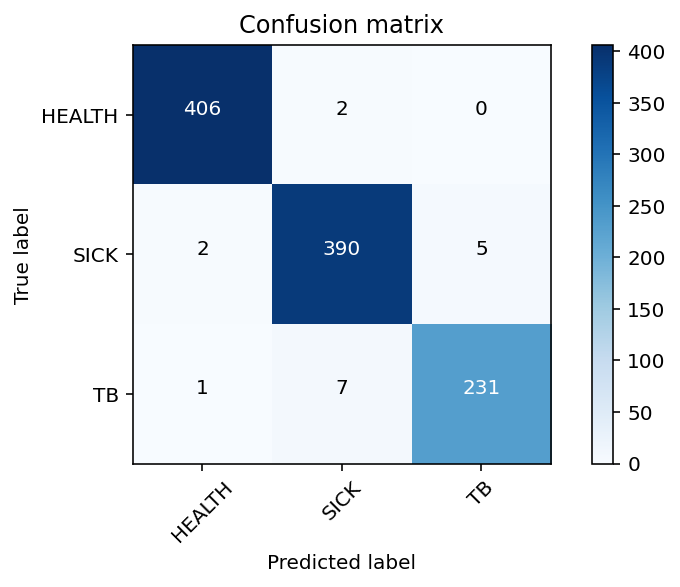

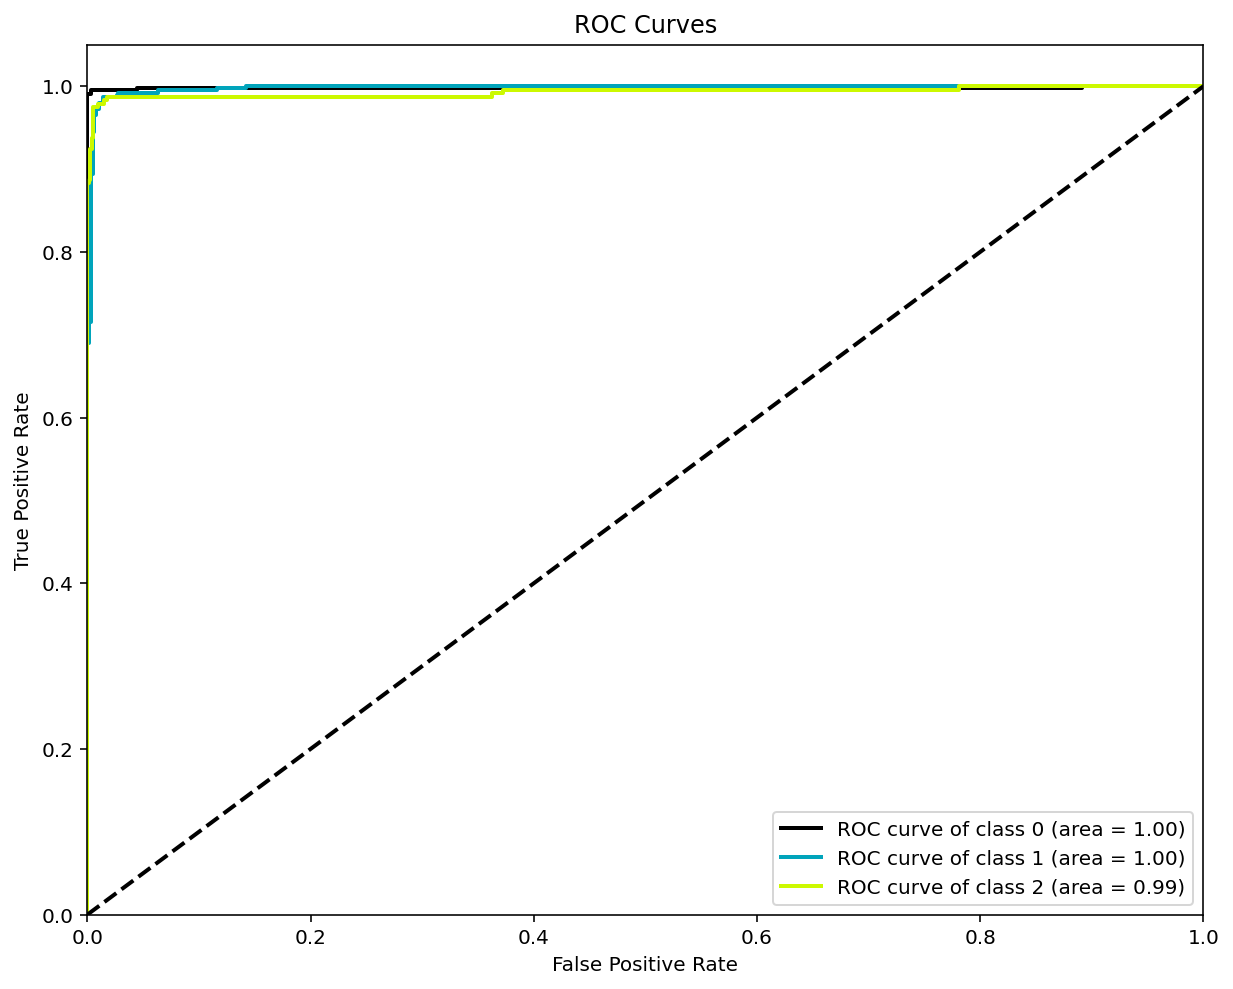

Inference completes in 0m 13s


In [16]:
%time
def compute_validate_meter(model, val_loader): # best_model_path,
    
    since = time.time()
    CHECK_POINT_PATH = 'tbx11k_vgg16.pth'
    try:
        checkpoint = torch.load(CHECK_POINT_PATH)
        print("checkpoint loaded")
    except:
        checkpoint = None
        print("checkpoint not found")

    def load_model(best_model_path):                                
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = copy.deepcopy(model.state_dict())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_loss = checkpoint['best_val_loss']
        best_acc = checkpoint['best_val_accuracy']
    load_model(CHECK_POINT_PATH)
    model.to(device)
    model.eval()
    pred_y = list()
    test_y = list()
    probas_y = list()
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device).float(), target.to(device)
            data, target = Variable(data), Variable(target)
            output = model(data)
            probas_y.extend(output.data.cpu().numpy().tolist())
            pred_y.extend(output.data.cpu().max(1, keepdim=True)[1].numpy().flatten().tolist())
            test_y.extend(target.data.cpu().numpy().flatten().tolist())
            
        # compute the confusion matrix
        confusion = confusion_matrix(test_y, pred_y)
        # plot the confusion matrix
        plot_labels = ['HEALTH', 'SICK', 'TB']

        plot_confusion_matrix(confusion, plot_labels)
        #plot_confusion_matrix(confusion, classes=val_loader.dataset.classes,title='Confusion matrix')
        # print Recall, Precision, F1-score, Accuracy
        report = classification_report(test_y, pred_y, digits=4)
        print("Report")
        print(report)
        plt_roc(test_y, probas_y)
        
    time_elapsed = time.time() - since
    print('Inference completes in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count = count_parameters(model)
print(count)

compute_validate_meter(model, data_loader['test']) #best_model_path,